In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Outlier_detection" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train
from Data_handling.RealNVP import FlowGMM

os.chdir("Outlier_detection")
os.getcwd()

'/Users/mattocallaghan/GES/Outlier_detection'

# Introduction

In this notebook we are going to probabilitsitcally find the distribution away from the fitted isochrone. Our first assumption is that the isochrone is properly fit. Therefore, no algorithmic fitting has been applied to the isochrone via our data or its error.

The first thing to note is that we will define a point $\vec{\hat{x}}$ in the HR diagram as having distribution $$ \vec{\hat{x}} \sim N(\vec{x},\Sigma) $$
where the hat denotes that it is an observed value.

Now we can marginalse out each of the observations
$$ \hat x_g \sim N(x_g,\sigma^2_g) $$
$$ \hat x_c \sim N(x_c,\sigma^2_c) $$
so that the first corresponds to the observation of the absolute magnitude and the second denotes the Gaia colour. We will assume their measurement is independent of eachother.

For a given point, let $m \in \mathbb{R}$ be the slope of a line perpendicular locally to the isochrone. Our tranformation will be $$ y=x_g-m x_c$$

Which, from the properties of Normal Distributions, has a distribution $$\hat y \sim N(x_g-mx_c,\sigma^2_g+m^2\sigma^2_c)$$

If we assume that the values $y=x_g-mx_c$ can be modelled with a Gaussian Mixture Model $$p(y)=\sum_j \alpha_j N(\bar y|m_j,\sigma^2_j)$$

Then using propetries of Gaussians we have that the observed $\hat y$ has the distribution $$p(\hat y)=\sum_j \alpha_j N(\bar y|m_j,\sigma^2_j+\sigma^2_g+m^2\sigma^2_c),$$
which is also a Gaussian Mixture.


# Import the Data

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_4917/1470587505.py:2: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  cluster_df=pd.read_csv('cluster_members_final.csv')


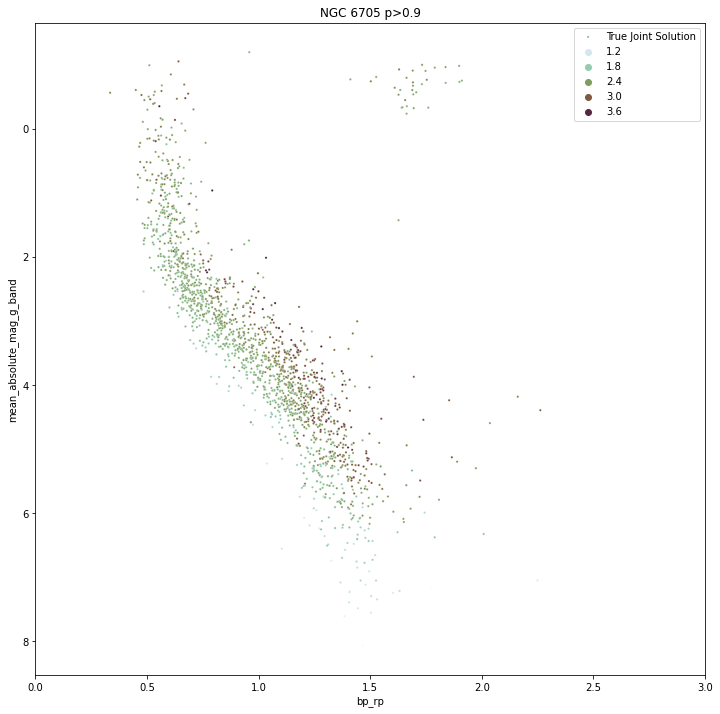

In [2]:
os.chdir("../cluster_files")
cluster_df=pd.read_csv('cluster_members_final.csv')
os.chdir("../Outlier_detection")


probability='p3'
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

cluster_df=cluster_df[cluster_df['phot_bp_mean_flux_error']<1000].reset_index(drop=True)

scatter=cluster_df[cluster_df[probability]>0.9]
orig_scatter=cluster_df[cluster_df[probability]>0.9]

sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo'],s=5,ax=axes,label='True Joint Solution',color='b', palette="ch:r=1,l=1.0")
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.xlim(0,3)
plt.show()

In [3]:
# Make some cuts
scatter=scatter[scatter['rgeo']>=1.8].reset_index(drop=True)
scatter=scatter[scatter['rgeo']<=2.5].reset_index(drop=True)
scatter=scatter[scatter['bp_rp']<=1.6].reset_index(drop=True)

orig_scatter=scatter

# Make common distance

1. We are assuming that everything is at the same distance because its in a cluster so we do that in the next step.

2. We will also make a cut so that its all main sequence. Basic cut for now.



In [4]:
scatter['rgeo']=scatter['rgeo'].median()
orig_scatter['rgeo']=scatter['rgeo'].median() #still assuming everything at the same distance
scatter['rgeo']=2.0
orig_scatter['rgeo']=2.0
def mean_basolute_mag_g_band(selection_gaia):
    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-5*np.log10(selection_gaia['rgeo']*1000)+5   #parsec
    return selection_gaia
mean_basolute_mag_g_band(scatter)
mean_basolute_mag_g_band(orig_scatter)

#cut main sequence
scatter=scatter[scatter.mean_absolute_mag_g_band>0.0].reset_index(drop=True)


We will order out data by the obsolute magnitude for now so that it looks like a function. This is so the Gaussian process works well.

In [5]:
scatter=scatter.sort_values(by=['mean_absolute_mag_g_band'])
orig_scatter=orig_scatter.sort_values(by=['mean_absolute_mag_g_band'])

# Add the Isochrone as data and overlay it on our data.

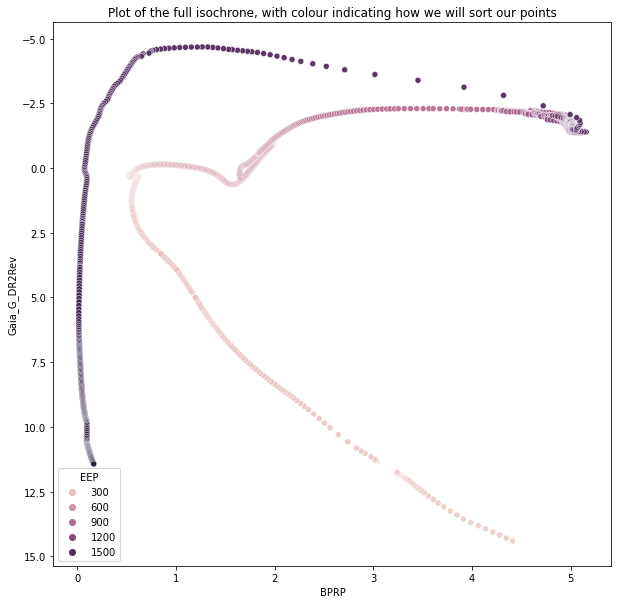

In [6]:
import pandas as pd
os.chdir('../Cluster_analysis')
columns=[str(i) for i in range (34)]
iso=pd.read_csv('iso.txt',delim_whitespace=True, names=columns)
isochrone=pd.DataFrame(iso[['0','22','23','24']].values[1:],columns=iso[['0','22','23','24']].values[0]).astype(float)

isochrone['BPRP']=isochrone['Gaia_BP_DR2Rev']-isochrone['Gaia_RP_DR2Rev']

fig,ax=plt.subplots(figsize=(10,10))

sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',hue='EEP',color='r')
plt.title('Plot of the full isochrone, with colour indicating how we will sort our points')
ax.invert_yaxis()

# H-R Diagram

We display the H-R diagram with the Gaussian Process, the Isochrone and our Data.

Extinction
1.24
feh=0.17
age 316e6 year

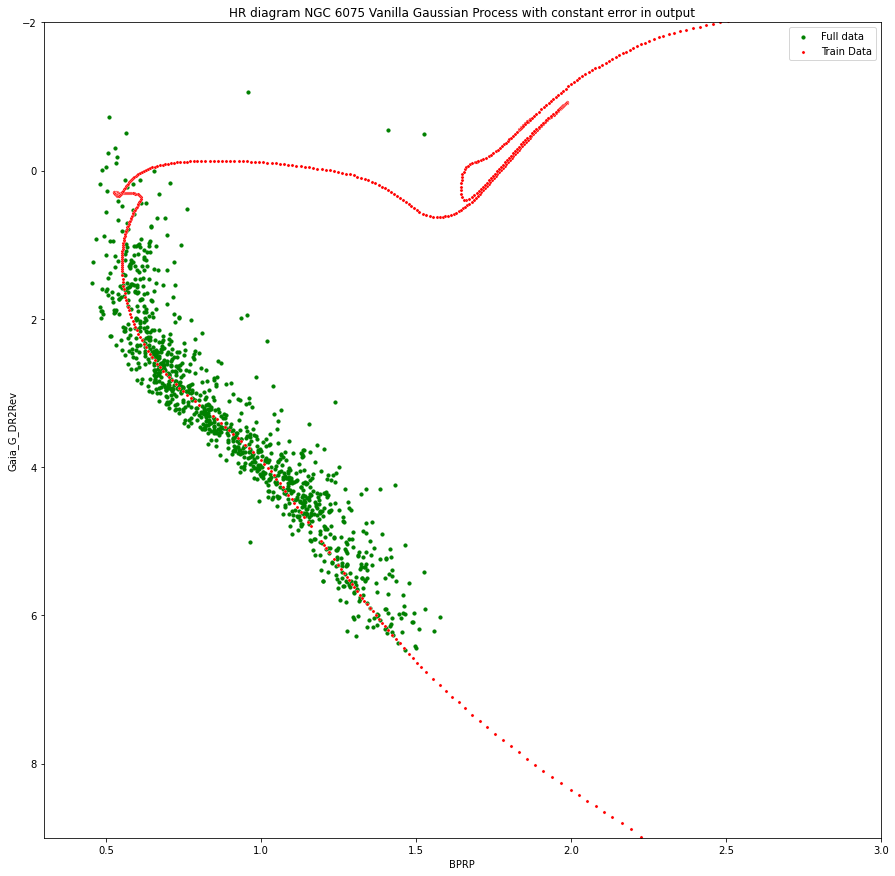

In [7]:
import torch
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15,15))

    # Get upper and lower confidence bounds
    # Plot training data as black stars
    #
    ax.scatter(orig_scatter['bp_rp'],orig_scatter['mean_absolute_mag_g_band'],s=10,color='g')
    
    # Plot predictive means as blue line

    # Shade between the lower and upper confidence bounds
    sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',color='r',ax=ax,s=10)
    ax.set_ylim(-2.0,9)
    
    ax.legend(['Full data','Train Data', 'Gauss Proc', 'Confidence','sIochrone'])
    ax.invert_yaxis()
    ax.set_xlim(0.3,3)
    
    
    plt.title('HR diagram NGC 6075 Vanilla Gaussian Process with constant error in output')

Change the range of the isochrone to restrict just to main sequence.

Also cut so that we have every third value of the isochrone.

In [8]:
isochrone=isochrone[isochrone['BPRP']<1.6].reset_index(drop=True)
isochrone=isochrone[isochrone['Gaia_G_DR2Rev']>1.0].reset_index(drop=True)
isochrone=isochrone[isochrone['Gaia_G_DR2Rev']<6.5].reset_index(drop=True)
isochrone=isochrone.sort_values(by='EEP').reset_index(drop=True)

#Take every third value
isochrone=isochrone.iloc()[::3,:].reset_index(drop=True)


# Distribution Function

The first thing we will do is look at the projection as a total, not as a perpendicular but just slicing everywhere at some angle. Later we will consider what happens when we take the perpendicular to the isochrone.

The next few lines of code just project the main sequence down at different anlges.

In [9]:
orig_scatter=orig_scatter[orig_scatter['mean_absolute_mag_g_band']>1.0]

In [10]:
import math
centers=[]
tests=[]
theta=90
for i in range(360):
    try:


        
        test=orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*(math.tan(i))

        tests.append(test.values)
        #tests.append(scaler.fit_transform(test.values.reshape(-1,1)))
    except:
        continue
        print(i)

Next we will see what that projection distribution looks like for different plots.

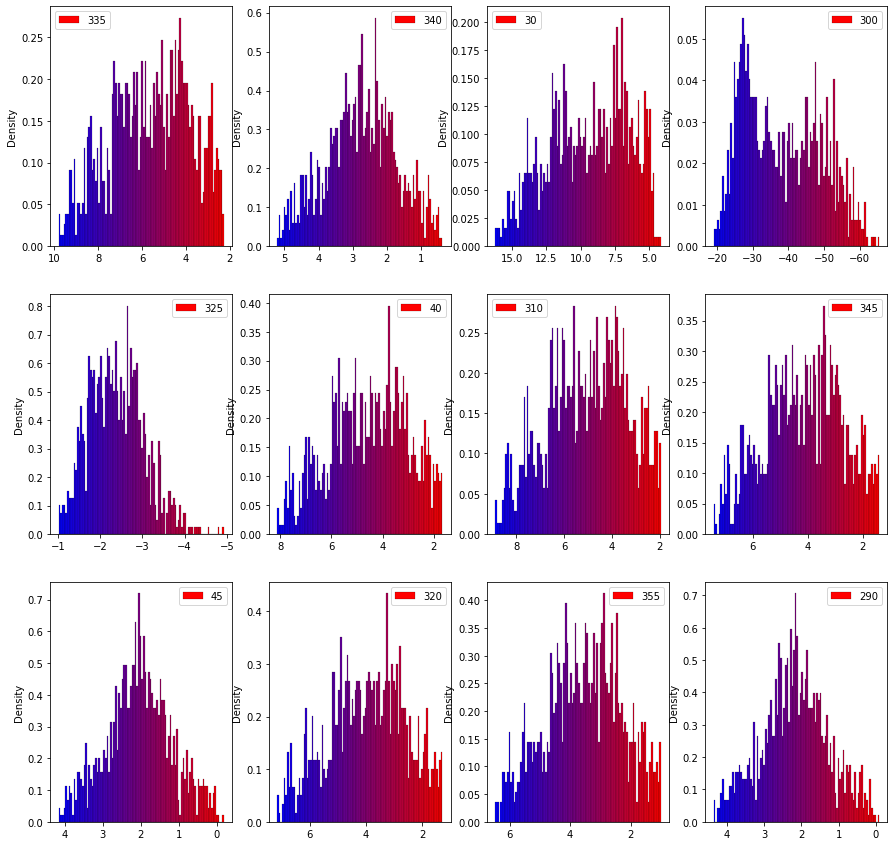

In [11]:
f, ax = plt.subplots(3, 4, figsize=(15,15))
angles=[300,310,320,335,345,355,340,325,290,30,40,45]
for i in range(len(angles)):
    sn.histplot(tests[angles[i]],ax=ax[i % 3,(11-i)%4],kde=False,legend=False,bins=100,stat='density',label=angles[i])
    for j in range(0,100):
        ax[i%3,(11-i)%4].patches[j].set_facecolor([1-j/100,0,j/100])
#sn.kdeplot(flat_test,ax=ax,color='orange')
    
    ax[i%3,(11-i)%4].invert_xaxis()
    ax[i%3,(11-i)%4].legend()

plt.show()

# Deconvolution GMM

In [12]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Cluster_analysis')

# G mag error understanding

We have no errors on the G mag, only on the G flux.

We also have zero point uncertainties.

sigmaG_0 = 0.0027553202
sigmaGBP_0 = 0.0027901700
sigmaGRP_0 = 0.0037793818

Let us see

In [13]:
(1/orig_scatter['phot_g_mean_flux_over_error']).max()

0.00823320453033726

This is an error of 1 percent. Hence, we will use the first order expansion of the taylor series

# Learning errors





Also assume the error on mean absolute mag comes exactly from the apperant in Gaia, for now.

In [14]:
orig_scatter['phot_g_mean_mag_error']=np.sqrt(((2.5/np.log(10))*orig_scatter['phot_g_mean_flux_error']/orig_scatter['phot_g_mean_flux'])**2+0.0027553202**2)
orig_scatter['bp_error']=np.sqrt(((2.5/np.log(10))*orig_scatter['phot_bp_mean_flux_error']/orig_scatter['phot_bp_mean_flux'])**2+0.0037793818**2)
orig_scatter['rp_error']=np.sqrt(((2.5/np.log(10))*orig_scatter['phot_rp_mean_flux_error']/orig_scatter['phot_rp_mean_flux'])**2+0.0027901700**2)

orig_scatter['bp_rp_error']=np.sqrt(orig_scatter['rp_error']**2+orig_scatter['bp_error']**2)

In [15]:
orig_scatter['y']=orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*(math.tan(240))
orig_scatter['y_err']=orig_scatter['phot_g_mean_mag_error']**2+(math.tan(240)*orig_scatter['bp_rp_error'])**2

In [16]:
orig_scatter['y']=orig_scatter['y'].replace('nan',0.0).fillna(0.0).astype(float)
orig_scatter['y_err']=orig_scatter['y_err'].replace('nan',0.0).fillna(0.0).astype(float)

orig_scatter['y_over_err']=orig_scatter['y']/orig_scatter['y_err']

<AxesSubplot:xlabel='y', ylabel='Count'>

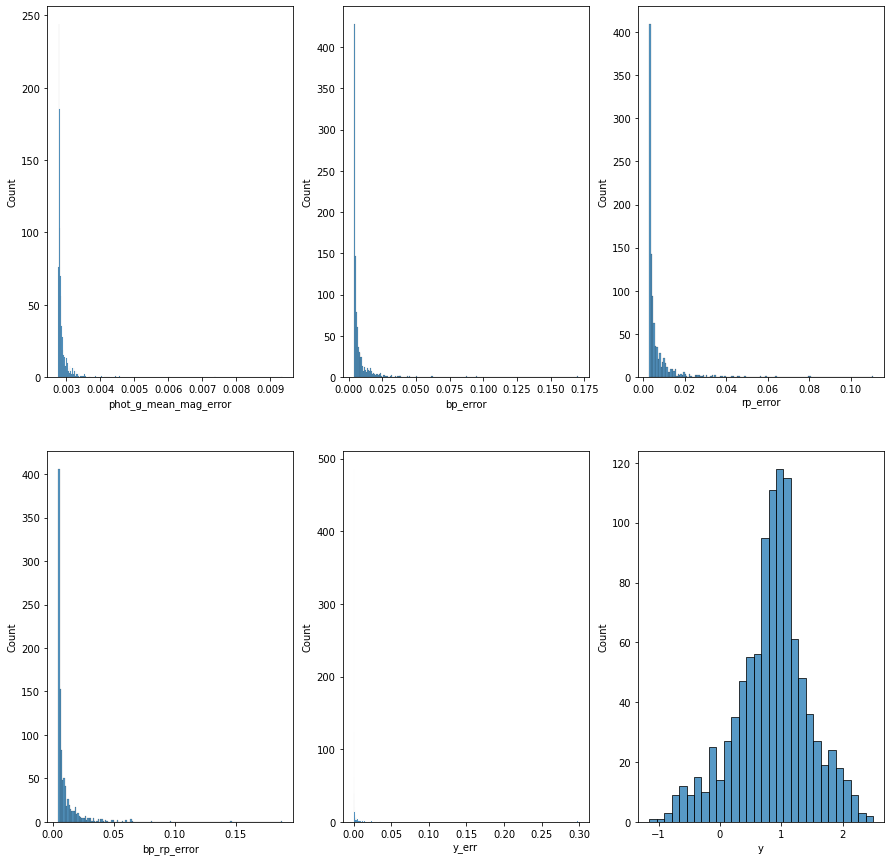

In [17]:
f, ax = plt.subplots(2, 3, figsize=(15,15))
sn.histplot(data=orig_scatter,x='phot_g_mean_mag_error',ax=ax[0,0])

sn.histplot(data=orig_scatter,x='bp_error',ax=ax[0,1])
sn.histplot(data=orig_scatter,x='rp_error',ax=ax[0,2])
sn.histplot(data=orig_scatter,x='bp_rp_error',ax=ax[1,0])
sn.histplot(data=orig_scatter,x='y_err',ax=ax[1,1])
sn.histplot(data=orig_scatter,x='y',ax=ax[1,2])


# Fit the GMM

# Using small segments

# Perpendicular Distribution

In [18]:
p_slopes=[]

x=isochrone['BPRP']
y=isochrone['Gaia_G_DR2Rev']
for i in range(len(isochrone)-1):    
    dy=y[i+1]-y[i]
    dx=x[i+1]-x[i]
    p_slopes.append(-1*dx/dy)
p_slopes.append(0)

In [19]:
isochrone['p_slopes']=p_slopes
isochrone['slopes']=-1/isochrone['p_slopes']

high_c=[]
low_c=[]
for i in range(len(isochrone)-1):
    high_c.append(isochrone['Gaia_G_DR2Rev'][i+1] - isochrone['p_slopes'][i]*isochrone['BPRP'][i+1])
    low_c.append(isochrone['Gaia_G_DR2Rev'][i] - isochrone['p_slopes'][i]*isochrone['BPRP'][i])
high_c.append(0)
low_c.append(0)

Set the Bounds of selection region for each part of the isochrone

In [20]:
isochrone['low_c']=high_c #high c is low c oops
isochrone['high_c']=low_c

In [21]:
isochrone=isochrone.loc()[0:len(isochrone)-2]

In [22]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [23]:
centers=[]
tests=[]
err_means=[]
for i in range(35):
    try:
        x=(orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*isochrone['p_slopes'][i]<=isochrone['high_c'][i])
        y=(isochrone['low_c'][i]<=orig_scatter['mean_absolute_mag_g_band']-orig_scatter['bp_rp']*isochrone['p_slopes'][i])
        
        test=orig_scatter[x]
        test=test[y]
        
        center=isochrone['Gaia_G_DR2Rev'][i] - isochrone['slopes'][i]*isochrone['BPRP'][i]
        test['y']=test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]
        test['y_err']=test['phot_g_mean_mag_error']**2+(isochrone['slopes'][i]*test['bp_rp_error'])**2
        
        centers.append(center)
        tests.append(test)
        err_means.append(test['y_err'].mean())
    except:
        continue
        print(i)
    

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_4917/2049842010.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test=test[y]
/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_4917/2049842010.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y']=test['mean_absolute_mag_g_band']-test['bp_rp']*isochrone['slopes'][i]
/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_4917/2049842010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tes

# When making a standard scaler transformation the variance from the error decrease by factor of $1/s^2$

In [24]:
for i in range(35):
    var=tests[i]['y'].replace('nan',0.0).fillna(0.0).astype(float).values.var()
    tests[i]['y']=scaler.fit_transform(tests[i]['y'].replace('nan',0.0).fillna(0.0).astype(float).values.reshape(-1,1))
    tests[i]['y_err']=tests[i]['y_err'].replace('nan',0.0).fillna(0.0).astype(float)/var
    gmm_GES=XDGMM(2).fit(tests[i]['y'].values.reshape(len(tests[i]),1),tests[i]['y_err'].values.reshape(len(tests[i]),1,1),R=np.array([1.0]*len(tests[i])).reshape(len(tests[i]),1,1))
    prob_ges=gmm_GES.prob_z_given_w(tests[i]['y'].values.reshape(len(tests[i]),1),tests[i]['y_err'].values.reshape(len(tests[i]),1,1),R=np.array([1.0]*len(tests[i])).reshape(len(tests[i]),1,1))
    if((prob_ges.transpose()[0]<=0.2).sum()>(prob_ges.transpose()[0]>0.2).sum()):
        tests[i]['probnew']=1-prob_ges.transpose()[0]
    else:
        tests[i]['probnew']=prob_ges.transpose()[0]


/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_4917/1658062235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tests[i]['y']=scaler.fit_transform(tests[i]['y'].replace('nan',0.0).fillna(0.0).astype(float).values.reshape(-1,1))
/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_4917/1658062235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tests[i]['y_err']=tests[i]['y_err'].replace('nan',0.0).fillna(0.0).astype(float)/var
/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykerne

In [25]:
tests2=[tests[i]['y'] for i in range (35)]
testserr=[tests[i]['y_err'] for i in range (35)]
x=[tests[i]['bp_rp'] for i in range (35)]
y=[tests[i]['mean_absolute_mag_g_band'] for i in range (35)]

p=[tests[i]['probnew'] for i in range (35)]

flat_test=[j for sublist in tests2 for j in sublist]
flat_test=np.array(flat_test).reshape(len(flat_test))

flat_testerr=[j for sublist in testserr for j in sublist]
flat_testerr=np.array(flat_testerr).reshape(len(flat_testerr))

flat_x=[j for sublist in x for j in sublist]
flat_x=np.array(flat_x).reshape(len(flat_x))

flat_y=[j for sublist in y for j in sublist]
flat_y=np.array(flat_y).reshape(len(flat_y))

flat_p=[j for sublist in p for j in sublist]
flat_p=np.array(flat_p).reshape(len(flat_p))


# Plot of projected values, projected and standardised at each interval.

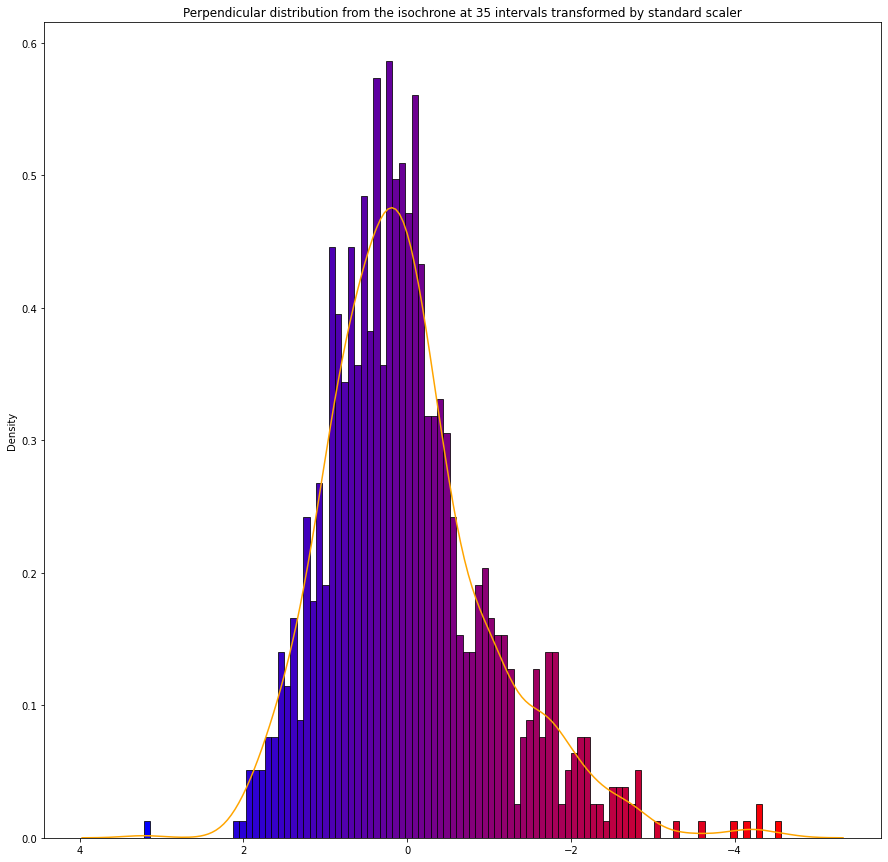

In [26]:

f, ax = plt.subplots(1, 1, figsize=(15,15))
plt.title('Perpendicular distribution from the isochrone at 35 intervals transformed by standard scaler')
sn.histplot(flat_test,ax=ax,kde=False,legend=False,bins=100,stat='density')
for i in range(0,100):
    ax.patches[i].set_facecolor([1-i/100,0,i/100])
sn.kdeplot(flat_test,ax=ax,color='orange')
ax.invert_xaxis()
plt.show()

# This next plot needs to be fixed so ignore.

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'HR diagram ')

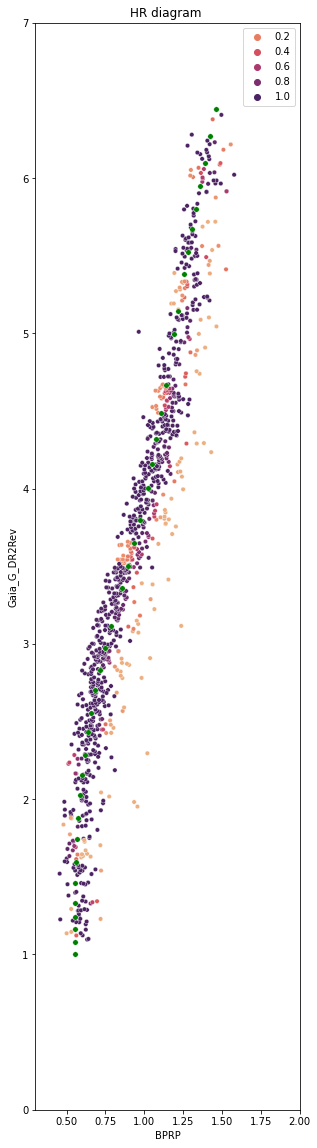

In [27]:
f, ax = plt.subplots(1, 1, figsize=(15,20))
import itertools
palette = itertools.cycle(sn.color_palette())


sn.scatterplot(flat_x,flat_y,hue=flat_p,s=20,palette=sn.color_palette("flare", as_cmap=True))
sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',color='g',ax=ax,s=30)


ax.set_ylim(0,7)

ax.set_aspect('equal', adjustable='box')

ax.set_xlim(0.3,2)


plt.title('HR diagram ')


In [28]:
#scaler.fit_transform(test['proj'].values.reshape(-1,1))

# An examle of one interval

In [29]:
x=tests[10]

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

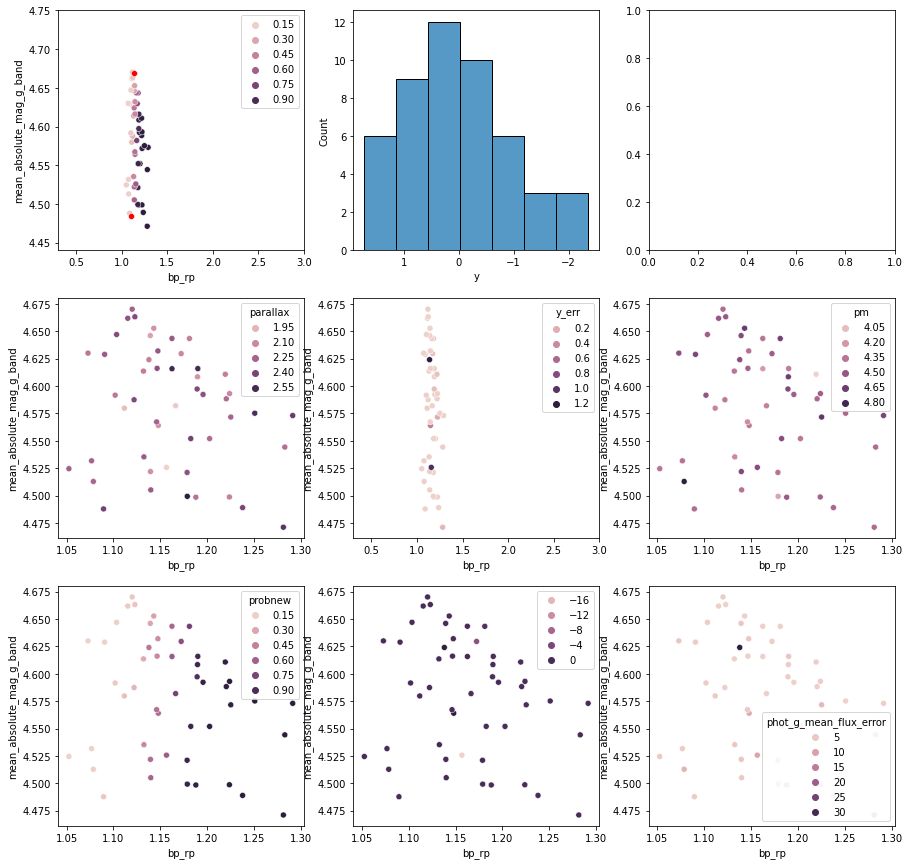

In [30]:
f, ax = plt.subplots(3, 3, figsize=(15,15))
sn.scatterplot(x['bp_rp'],x['mean_absolute_mag_g_band'],hue=x['probnew'],ax=ax[0,0])
sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',color='r',ax=ax[0,0])
sn.histplot(data=x,x='y',ax=ax[0,1])

sn.scatterplot(x['bp_rp'],x['mean_absolute_mag_g_band'],hue=x['y_err'],ax=ax[1,1])

sn.scatterplot(x['bp_rp'],x['mean_absolute_mag_g_band'],hue=1/x['parallax'],ax=ax[1,0])

sn.scatterplot(x['bp_rp'],x['mean_absolute_mag_g_band'],hue=x['pm'],ax=ax[1,2])


sn.scatterplot(x['bp_rp'],x['mean_absolute_mag_g_band'],hue=x['probnew'],ax=ax[2,0])
sn.scatterplot(x['bp_rp'],x['mean_absolute_mag_g_band'],hue=x['y_err']/x['y'],ax=ax[2,1])

sn.scatterplot(x['bp_rp'],x['mean_absolute_mag_g_band'],hue=x['phot_g_mean_flux_error'],ax=ax[2,2])


ax[0,0].set_ylim(4.44,4.75)
ax[0,0].set_xlim(0.3,3)
ax[1,1].set_xlim(0.3,3)

ax[0,1].invert_xaxis()



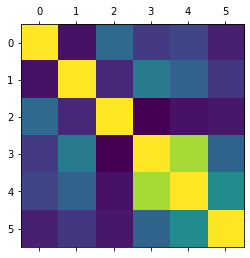

,probnew,pmra,pmdec,phot_g_mean_flux_error,y_err,parallax
probnew,1.000000,-0.187020,0.180116,-0.033698,0.012826,-0.138872
pmra,-0.187020,1.000000,-0.105394,0.260223,0.146403,-0.045049
pmdec,0.180116,-0.105394,1.000000,-0.248105,-0.188782,-0.165338
phot_g_mean_flux_error,-0.033698,0.260223,-0.248105,1.000000,0.832342,0.155745
y_err,0.012826,0.146403,-0.188782,0.832342,1.000000,0.356767
parallax,-0.138872,-0.045049,-0.165338,0.155745,0.356767,1.000000


In [31]:
dataframe=x[['probnew','pmra','pmdec','phot_g_mean_flux_error','y_err','parallax']]

plt.matshow(dataframe.corr())
plt.show()
dataframe.corr()

# All data

In [32]:
tests2=[tests[i]['y'] for i in range (35)]
testserr=[tests[i]['y_err'] for i in range (35)]
x=[tests[i]['bp_rp'] for i in range (35)]
y=[tests[i]['mean_absolute_mag_g_band'] for i in range (35)]

flat_test=[j for sublist in tests2 for j in sublist]
flat_test=np.array(flat_test).reshape(len(flat_test))

flat_testerr=[j for sublist in testserr for j in sublist]
flat_testerr=np.array(flat_testerr).reshape(len(flat_testerr))

flat_x=[j for sublist in x for j in sublist]
flat_x=np.array(flat_x).reshape(len(flat_x))

flat_y=[j for sublist in y for j in sublist]
flat_y=np.array(flat_y).reshape(len(flat_y))

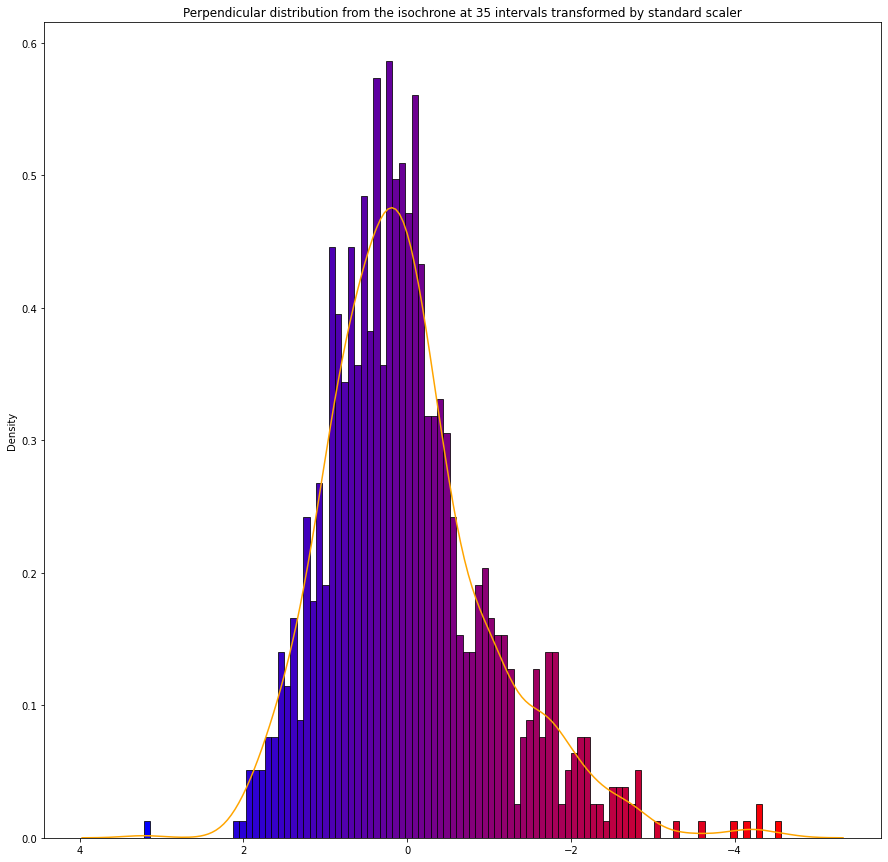

In [33]:

f, ax = plt.subplots(1, 1, figsize=(15,15))
plt.title('Perpendicular distribution from the isochrone at 35 intervals transformed by standard scaler')
sn.histplot(flat_test,ax=ax,kde=False,legend=False,bins=100,stat='density')
for i in range(0,100):
    ax.patches[i].set_facecolor([1-i/100,0,i/100])
sn.kdeplot(flat_test,ax=ax,color='orange')
ax.invert_xaxis()
plt.show()

In [34]:
gmm_GES=XDGMM(2).fit(flat_test.reshape(len(flat_test),1),flat_testerr.reshape(len(flat_test),1,1),R=np.array([1.0]*len(flat_testerr)).reshape(len(flat_testerr),1,1))
prob_ges=gmm_GES.prob_z_given_w(flat_test.reshape(len(flat_test),1),flat_testerr.reshape(len(flat_test),1,1),R=np.array([1.0]*len(flat_testerr)).reshape(len(flat_testerr),1,1))


In [35]:
#sn.scatterplot(flat_x,flat_y,hue=prob_ges.transpose()[0],s=20,palette=sn.color_palette("flare", as_cmap=True))


/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'prob of being assigned to main sequence <0.01')

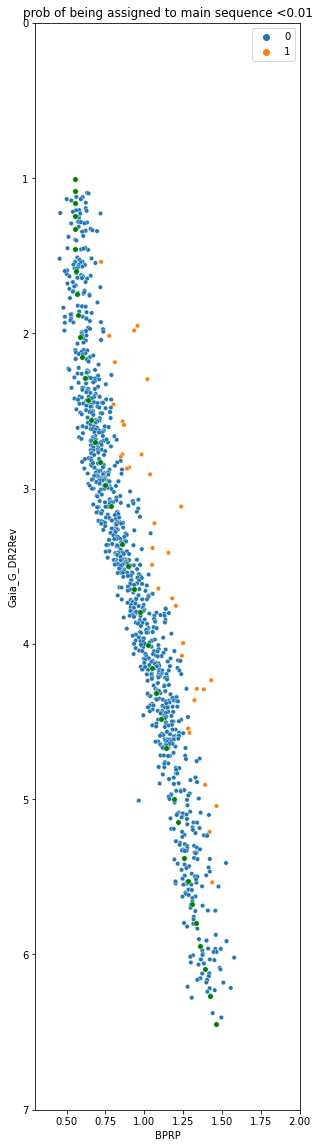

In [36]:
f, ax = plt.subplots(1, 1, figsize=(15,20))
import itertools
palette = itertools.cycle(sn.color_palette())

indicator=(prob_ges.transpose()[0]<0.01).astype(int)

sn.scatterplot(flat_x,flat_y,hue=indicator,s=20)
sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',color='g',ax=ax,s=30)


ax.set_ylim(0,7)

ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()
ax.set_xlim(0.3,2)


plt.title('prob of being assigned to main sequence <0.01')


# Plot the probabilities

/opt/homebrew/Caskroom/miniforge/base/envs/astro/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'HR diagram with probability')

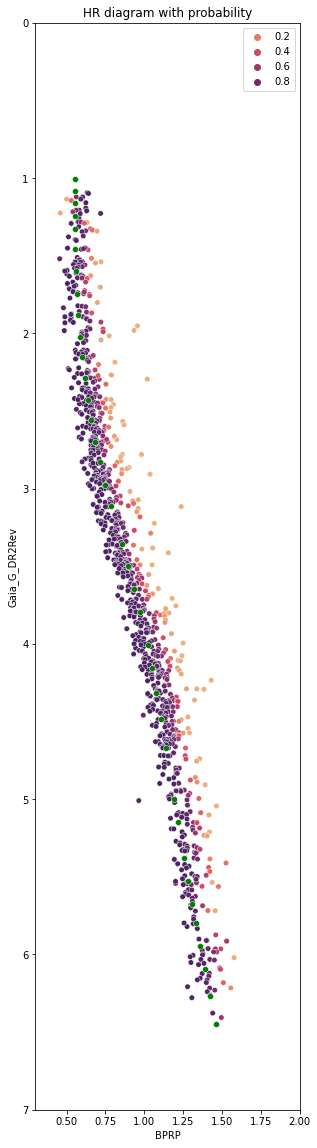

In [41]:
f, ax = plt.subplots(1, 1, figsize=(15,20))
import itertools
palette = itertools.cycle(sn.color_palette())


sn.scatterplot(flat_x,flat_y,hue=prob_ges.transpose()[0],s=30,palette=sn.color_palette("flare", as_cmap=True))
sn.scatterplot(data=isochrone,x='BPRP',y='Gaia_G_DR2Rev',color='g',ax=ax)


ax.set_ylim(0,7)

ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()
ax.set_xlim(0.3,2)


plt.title('HR diagram with probability')
